# Note on Omitted Variable Bias vs. Confounding bias

The two concepts are related, but not quite the same. This note demonstrates the difference and discusses when omitted variable bias is a problem, and when not.

References:
 - Pearl (2009): Causality - Models, Reasoning, and Inference
 - Hayashi (2000): Econometrics

In [1]:
import statsmodels.api as sm
import statsmodels.formula.api as sm_form
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.stats.moment_helpers import corr2cov
np.random.seed(5000)

import rpy2
%load_ext rpy2.ipython

In [2]:
%%R 
library(dagitty)

Consider a simple OLS regression. Coefficient estimate for variable $S$, $\beta$, can be asymptotically biased if a relevant variable – i.e. a variable that is a) determinant of the dependent variable $W$, and b) correlated with $S$ – is omitted from the regression equation. Then we say that estimate $\hat{\beta}$ suffers from omitted variable bias (OVB). However, this is not always problematic! It all depends what effect one is interested in.  

## Omitted variable bias and direct causal effects

If one is interested in estimating the **direct causal effect** of $S$ on outcome variable $Y$ – i.e the causal effect $S$ has on $Y$ excluding all causal effects mediated via other variables of the system – then **OVB will always pose a problem**. To see this, consider a simple regression problem inspired by Hayashi (2000, p. 237; problem slightly modified from the original), where an attempt is made to estimate effects of schooling and ability on wage:

$$W = \alpha + \beta S + \gamma A \ \ \text{,}$$

where $W$ denotes wage, $S$ denotes years of schooling, and $A$ denotes ability of the individual. For this simplified demonstration it is assumed that in the underlying *data generating process* (DGP) schooling and ability are indeed the only determinants of wage. Further, we first assume that whereas schooling affects wage directly, ability affects both schooling and wage. We can represent the causal effects by a following directed acyclic graph (DAG), where we draw the three variables ($S$, $A$, $W$), causal effects between them (arrows) and the magnitude of each effect (denoted by $E_i$); for example, the (direct) causal effect of $A$ on $S$ is $E_1$.

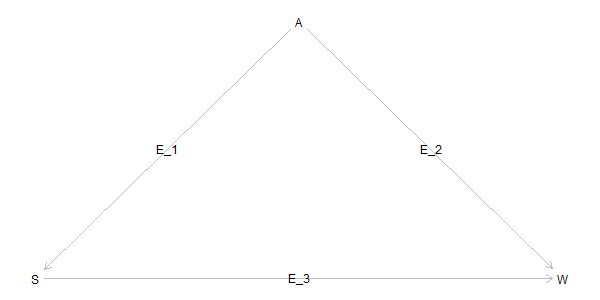

In [3]:
%%R -h 300 -w 600
g = dagitty( 'dag {
    "S" [pos="0,2"]
    "A" [pos="2,0"]
    "W" [pos="4,2"]

    "E_1" [pos="1,1"]
    "E_2" [pos="3,1"]
    "E_3" [pos="2,2"]

    "S" <- "A" -> "W"
    "S" -> "W"
}')
plot(g)

In this case regression

$$W = \alpha + \beta S + \gamma A$$

would result in estimate $\hat{\beta}$ being an asymptotically unbiased estimate for effect $E_3$ and estimate $\hat{\gamma}$ being an asymptotically unbiased estimate for effect $E_2$. That is, $\text{plim } \hat{\beta} = E_3$ and $\text{plim } \hat{\gamma} = E_2$.

If $A$ was omitted from the regression, i.e. we ran regression

$$W = \alpha + \beta S \ \ \text{,}$$

then the estimate $\hat{\beta}$ would be a biased estimate of the effect $E_1$. Indeed, we'd have

$$\text{plim } \hat{\beta} = E_3 + E_1 * E_2 \neq E_3$$

due to the direct effect of schooling ($E_1$) as well as "indirect" or "back-door" effect of ability on wages (as $A$ and $S$ are correlated).

What if the direction of the causal effect $E_1$ was changed in the underlying DGP? That is:

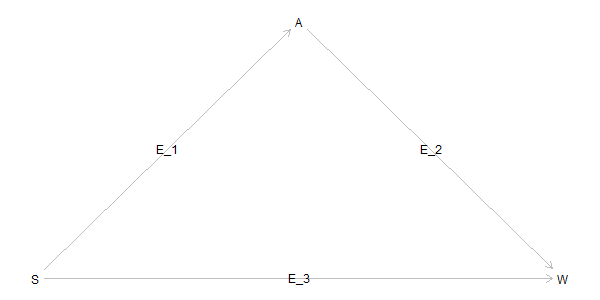

In [4]:
%%R -h 300 -w 600
g = dagitty( 'dag {
    "S" [pos="0,2"]
    "A" [pos="2,0"]
    "W" [pos="4,2"]

    "E_1" [pos="1,1"]
    "E_2" [pos="3,1"]
    "E_3" [pos="2,2"]

    "S" -> "A" -> "W"
    "S" -> "W"
}')
plot(g)

Well, as long as we are interested in estimating the **direct causal effect** of $S$ on $W$ this would not change anything: regression

$$W = \alpha + \beta S + \gamma A$$

would still yield unbiased estimate $\hat{\beta}$ for effect $E_3$ and unbiased estimate $\hat{\gamma}$ for effect $E_2$. If $A$ was omitted from the regression, i.e.

$$W = \alpha + \beta S \ \ \text{,}$$

then again 

$$\text{plim } \hat{\beta} = E_3 + E_1 * E_2 \neq E_3 \ \ \text{,}$$

that is we estimate the effect $E_3$ with a bias.

## Omitted variable bias, total causal effects, and confounding bias

Things change drastically if we are interested in the **total causal effect** of $S$ on $W$. By "total effect" we mean the total *causal* effect $S$ has on $W$, i.e. how would $W$ react were one to modify $S$ (e.g. by one year). If we can estimate this total causal effect without a bias, the we say our estimate is without **confounding bias**. 

To set the stage, we reproduce the definition of non-confoundness from Pearl (2009, Definition 6.2.1):

*Let $M$ be a causal model of the data generating process – that is, a formal description of how the value of each observed variable is determined. Denote by $P(y | do(x))$ the probability of the response event $Y=y$ under the hypothetical intervention $X=x$, calculated according to $M$. We say that $X$ and $Y$ are not confounded in $M$ if and only if*

$$P(y | do(x)) = P(y | x) \text{, or } P(x | do(y)) = P(x|y) \quad \text{6.10}$$

*for all $x$ and $y$ in their respective domains, where $P(y | x)$ is the conditional probability generated by $M$. If (6.10) holds, we say that $P(y|x)$ is unbiased*.

In this formal definition $do()$ denotes the [do-calculus](https://en.wikipedia.org/wiki/Causal_model#Do_calculus) operator. The formal definition might seem complicated, and to accompany it Pearl (2009, p. 183; reproduced here with slight modification) also offers an association-based definition which might be more familiar to e.g. statisticians and econometricians:

*Two variables $X$ and $Y$ are not confounded if and only if every variable $Z$ that is not affected by $X$ is either 1) unassociated with X or 2) unassociated with $Y$, conditional on $X$*.

Now we can see what this means in context of our example. From the two variations above let's first consider the situation where in the DGP $S$ causally affects $A$: 

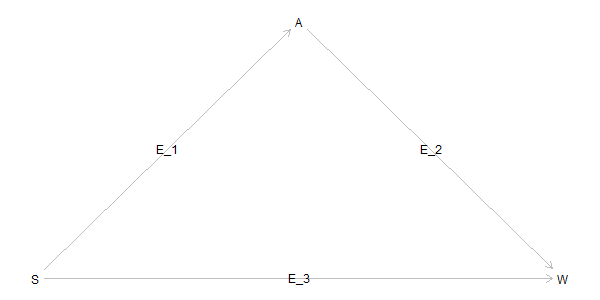

In [5]:
%%R -h 300 -w 600
g = dagitty( 'dag {
    "S" [pos="0,2"]
    "A" [pos="2,0"]
    "W" [pos="4,2"]

    "E_1" [pos="1,1"]
    "E_2" [pos="3,1"]
    "E_3" [pos="2,2"]

    "S" -> "A" -> "W"
    "S" -> "W"
}')
plot(g)

Let's remind ourselves we are now not interested to estimate the direct causal effect $E_3$, but rather the **total causal effect** of change in $S$ would induce on $W$. This total effect can be calculated to be the sum of direct effect $E_3$ and the mediated effect $E_1 * E_2$ via $A$: $E_3 + E_1 * E_2$. Now observe what happens when we run regression

$$W = \alpha + \beta S + \gamma A$$

From above we know that this yields asymptotically unbiased estimates $\text{plim } \hat{\beta} = E_3$ and $\text{plim } \hat{\gamma} = E_2$. But **this is not correct given our aim to estimate the total causal effect** $E_3 + E_1 * E_2$! Here controlling for $A$ introduces a *mediator confounding bias* on the causal effect. Note, however, that the estimates are totally fine (i.e. unbiased) for the direct effects; it is just not what we are after now!

What about the regression with omitted variable:

$$W = \alpha + \beta S$$

Again from above we know that $\text{plim } \hat{\beta} = E_3 + E_1 * E_2$, which is exactly what we wanted! This means that **although this regression suffers from OVB, it does not suffer from confounding bias**! We can see this also from the non-formal definition of non-confoundness: $A$ is the only other variable in the system besides exposure $S$ and outcome $W$, and as $A$ is directly affected by $S$, then the definition is satisfied and $W$ and $S$ are not confounded without any additional adjustments.

What about the second variation where in the DGP $A$ causally affects $S$:

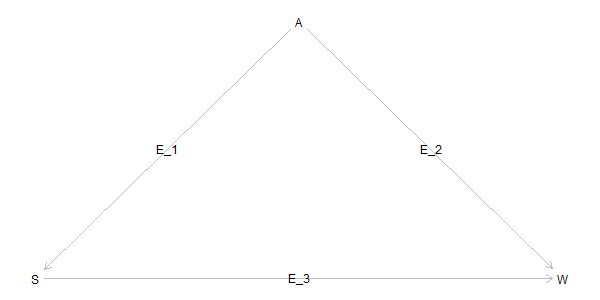

In [6]:
%%R -h 300 -w 600
g = dagitty( 'dag {
    "S" [pos="0,2"]
    "A" [pos="2,0"]
    "W" [pos="4,2"]

    "E_1" [pos="1,1"]
    "E_2" [pos="3,1"]
    "E_3" [pos="2,2"]

    "S" <- "A" -> "W"
    "S" -> "W"
}')
plot(g)

In this case the **total and direct effects of $S$ on $W$ coincide** and both equal $E_1$. To estimate $E_1$ in unbiased fashion (i.e. no confounding bias) it is very important to control for $A$ in the regression, i.e. the correct regression to run is

$$W = \alpha + \beta S + \gamma A$$

This regression **suffers neither from OVB or confounding bias**. Again, this can be see from the non-formal definition of definition of non-confoundness: now $A$ is not directly affect by $S$, but it is associated with $X$, and it is associated with $W$ conditional on $S$. Hence, the definition says $W$ and $S$ are confounded, and this confounding bias needs to be accounted for.